# Statistical Modeling: Claim Severity and Premium Prediction

This notebook builds predictive models for:
1. **Claim Severity Prediction**: Predict TotalClaims for policies with claims > 0
2. **Premium Optimization**: Predict optimal premium values

## Models to Implement
- Linear Regression
- Decision Trees
- Random Forests
- XGBoost

## Evaluation Metrics
- RMSE (Root Mean Squared Error)
- R² (Coefficient of Determination)
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)

## Model Interpretability
- Feature Importance Analysis
- SHAP (SHapley Additive exPlanations)
- LIME (Local Interpretable Model-agnostic Explanations)


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(str(Path().resolve().parent))

from src.data.load_data import load_insurance_data
from src.utils.config import REPORTS_DIR, MODELS_DIR
from src.modeling.data_preparation import (
    prepare_claim_severity_data,
    prepare_premium_prediction_data
)
from src.modeling.models import (
    train_linear_regression,
    train_decision_tree,
    train_random_forest,
    evaluate_model,
    compare_models
)

# Import XGBoost only if available
try:
    from src.modeling.models import train_xgboost
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. XGBoost models will be skipped.")
    print("Install with: pip install xgboost")
from src.modeling.interpretability import (
    get_feature_importance,
    plot_feature_importance,
    explain_with_shap,
    plot_shap_summary
)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

# Create directories
FIGURES_DIR = REPORTS_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
# Load data
df = load_insurance_data()
print(f"Dataset loaded: {len(df):,} rows, {len(df.columns)} columns")
print(f"\nPolicies with claims: {len(df[df['TotalClaims'] > 0]):,}")
print(f"Policies without claims: {len(df[df['TotalClaims'] == 0]):,}")


Loading data from: /Users/danielmituku/Documents/10Academy/week3/End-to-End-Insurance-Risk-Analytics-Predictive-Modeling/data/raw/MachineLearningRating_v3.txt
Loaded 1000098 rows and 52 columns
Dataset loaded: 1,000,098 rows, 52 columns

Policies with claims: 2,788
Policies without claims: 997,305


## Model 1: Claim Severity Prediction

Predict TotalClaims for policies that have claims > 0.


In [3]:
# Prepare data for claim severity prediction
X_train_sev, X_test_sev, y_train_sev, y_test_sev, feature_names_sev, preprocessor_sev = \
    prepare_claim_severity_data(df, target_col='TotalClaims', test_size=0.2)

print(f"Training set: {X_train_sev.shape[0]:,} samples, {X_train_sev.shape[1]} features")
print(f"Test set: {X_test_sev.shape[0]:,} samples")
print(f"\nTarget (TotalClaims) statistics:")
print(f"  Mean: {y_train_sev.mean():.2f} ZAR")
print(f"  Median: {y_train_sev.median():.2f} ZAR")
print(f"  Std: {y_train_sev.std():.2f} ZAR")


Available columns in dataset: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode']...
Using 12 features: ['Province', 'PostalCode', 'Gender', 'MaritalStatus', 'VehicleType']...
Training set: 2,230 samples, 57 features
Test set: 558 samples

Target (TotalClaims) statistics:
  Mean: 23275.76 ZAR
  Median: 6140.35 ZAR
  Std: 38365.38 ZAR


In [4]:
# Train all models for claim severity prediction
models_sev = {}

print("Training models for Claim Severity Prediction...")
print("="*80)

# Linear Regression
print("\n1. Training Linear Regression...")
model_lr, train_metrics_lr = train_linear_regression(X_train_sev, y_train_sev)
models_sev['Linear Regression'] = (model_lr, train_metrics_lr)
test_metrics_lr = evaluate_model(model_lr, X_test_sev, y_test_sev)
print(f"   Test RMSE: {test_metrics_lr['rmse']:.2f}, Test R²: {test_metrics_lr['r2']:.4f}")

# Decision Tree
print("\n2. Training Decision Tree...")
model_dt, train_metrics_dt = train_decision_tree(X_train_sev, y_train_sev, max_depth=10)
models_sev['Decision Tree'] = (model_dt, train_metrics_dt)
test_metrics_dt = evaluate_model(model_dt, X_test_sev, y_test_sev)
print(f"   Test RMSE: {test_metrics_dt['rmse']:.2f}, Test R²: {test_metrics_dt['r2']:.4f}")

# Random Forest
print("\n3. Training Random Forest...")
model_rf, train_metrics_rf = train_random_forest(X_train_sev, y_train_sev, n_estimators=100)
models_sev['Random Forest'] = (model_rf, train_metrics_rf)
test_metrics_rf = evaluate_model(model_rf, X_test_sev, y_test_sev)
print(f"   Test RMSE: {test_metrics_rf['rmse']:.2f}, Test R²: {test_metrics_rf['r2']:.4f}")

# XGBoost (only if available)
if XGBOOST_AVAILABLE:
    print("\n4. Training XGBoost...")
    try:
        model_xgb, train_metrics_xgb = train_xgboost(X_train_sev, y_train_sev, n_estimators=100)
        models_sev['XGBoost'] = (model_xgb, train_metrics_xgb)
        test_metrics_xgb = evaluate_model(model_xgb, X_test_sev, y_test_sev)
        print(f"   Test RMSE: {test_metrics_xgb['rmse']:.2f}, Test R²: {test_metrics_xgb['r2']:.4f}")
    except Exception as e:
        print(f"   XGBoost training failed: {e}")
        print("   Continuing with other models...")
else:
    print("\n4. Skipping XGBoost (not available)")

print("\n" + "="*80)
print("All models trained successfully!")


Training models for Claim Severity Prediction...

1. Training Linear Regression...
   Test RMSE: 34148.28, Test R²: 0.2749

2. Training Decision Tree...
   Test RMSE: 37701.53, Test R²: 0.1162

3. Training Random Forest...
   Test RMSE: 34279.47, Test R²: 0.2693

4. Training XGBoost...
   XGBoost training failed: XGBoost is not available: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/danielmituku/Documents/10Academy/week3/End-to-End-Insurance-Risk-Analytics-Predictive-Modeling/.venv/lib/python3.14/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <636BF463-1886-392D-B8B3-6011C44DC

In [5]:
# Compare all models
comparison_sev = compare_models(models_sev, X_test_sev, y_test_sev)
print("\nModel Comparison - Claim Severity Prediction:")
print("="*80)
print(comparison_sev.to_string(index=False))

# Identify best model
best_model_sev = comparison_sev.loc[comparison_sev['Test_R2'].idxmax(), 'Model']
print(f"\nBest Model (by R²): {best_model_sev}")
print(f"  Test R²: {comparison_sev.loc[comparison_sev['Test_R2'].idxmax(), 'Test_R2']:.4f}")
print(f"  Test RMSE: {comparison_sev.loc[comparison_sev['Test_R2'].idxmax(), 'Test_RMSE']:.2f} ZAR")



Model Comparison - Claim Severity Prediction:
            Model   Train_RMSE  Train_R2    Test_RMSE  Test_R2     Test_MAE  Test_MAPE
Linear Regression 31972.196334  0.305198 34148.275185 0.274922 17599.023377 372.093048
    Decision Tree 25794.245008  0.547768 37701.529063 0.116178 16395.652908 242.730921
    Random Forest 23679.711774  0.618874 34279.468024 0.269340 15612.752804 248.195723

Best Model (by R²): Linear Regression
  Test R²: 0.2749
  Test RMSE: 34148.28 ZAR


## Model 2: Premium Prediction

Predict optimal premium values.


In [6]:
# Prepare data for premium prediction
X_train_prem, X_test_prem, y_train_prem, y_test_prem, feature_names_prem, preprocessor_prem = \
    prepare_premium_prediction_data(df, target_col='TotalPremium', test_size=0.2)

print(f"Training set: {X_train_prem.shape[0]:,} samples, {X_train_prem.shape[1]} features")
print(f"Test set: {X_test_prem.shape[0]:,} samples")
print(f"\nTarget (TotalPremium) statistics:")
print(f"  Mean: {y_train_prem.mean():.2f} ZAR")
print(f"  Median: {y_train_prem.median():.2f} ZAR")
print(f"  Std: {y_train_prem.std():.2f} ZAR")


Training set: 799,848 samples, 101 features
Test set: 199,962 samples

Target (TotalPremium) statistics:
  Mean: 61.95 ZAR
  Median: 2.18 ZAR
  Std: 242.00 ZAR


In [7]:
# Train all models for premium prediction
models_prem = {}

print("Training models for Premium Prediction...")
print("="*80)

# Linear Regression
print("\n1. Training Linear Regression...")
model_lr_prem, train_metrics_lr_prem = train_linear_regression(X_train_prem, y_train_prem)
models_prem['Linear Regression'] = (model_lr_prem, train_metrics_lr_prem)
test_metrics_lr_prem = evaluate_model(model_lr_prem, X_test_prem, y_test_prem)
print(f"   Test RMSE: {test_metrics_lr_prem['rmse']:.2f}, Test R²: {test_metrics_lr_prem['r2']:.4f}")

# Decision Tree
print("\n2. Training Decision Tree...")
model_dt_prem, train_metrics_dt_prem = train_decision_tree(X_train_prem, y_train_prem, max_depth=10)
models_prem['Decision Tree'] = (model_dt_prem, train_metrics_dt_prem)
test_metrics_dt_prem = evaluate_model(model_dt_prem, X_test_prem, y_test_prem)
print(f"   Test RMSE: {test_metrics_dt_prem['rmse']:.2f}, Test R²: {test_metrics_dt_prem['r2']:.4f}")

# Random Forest
print("\n3. Training Random Forest...")
model_rf_prem, train_metrics_rf_prem = train_random_forest(X_train_prem, y_train_prem, n_estimators=100)
models_prem['Random Forest'] = (model_rf_prem, train_metrics_rf_prem)
test_metrics_rf_prem = evaluate_model(model_rf_prem, X_test_prem, y_test_prem)
print(f"   Test RMSE: {test_metrics_rf_prem['rmse']:.2f}, Test R²: {test_metrics_rf_prem['r2']:.4f}")

# XGBoost (only if available)
if XGBOOST_AVAILABLE:
    print("\n4. Training XGBoost...")
    try:
        model_xgb_prem, train_metrics_xgb_prem = train_xgboost(X_train_prem, y_train_prem, n_estimators=100)
        models_prem['XGBoost'] = (model_xgb_prem, train_metrics_xgb_prem)
        test_metrics_xgb_prem = evaluate_model(model_xgb_prem, X_test_prem, y_test_prem)
        print(f"   Test RMSE: {test_metrics_xgb_prem['rmse']:.2f}, Test R²: {test_metrics_xgb_prem['r2']:.4f}")
    except Exception as e:
        print(f"   XGBoost training failed: {e}")
        print("   Continuing with other models...")
else:
    print("\n4. Skipping XGBoost (not available)")

print("\n" + "="*80)
print("All models trained successfully!")


Training models for Premium Prediction...

1. Training Linear Regression...
   Test RMSE: 118.50, Test R²: 0.5454

2. Training Decision Tree...
   Test RMSE: 108.03, Test R²: 0.6221

3. Training Random Forest...
   Test RMSE: 107.59, Test R²: 0.6252

4. Training XGBoost...
   XGBoost training failed: XGBoost is not available. Please install it with: pip install xgboost
If you're on macOS with Apple Silicon, try: pip install xgboost --upgrade
   Continuing with other models...

All models trained successfully!


In [13]:
# Compare all models for premium prediction
comparison_prem = compare_models(models_prem, X_test_prem, y_test_prem)
print("\nModel Comparison - Premium Prediction:")
print("="*80)
print(comparison_prem.to_string(index=False))

# Identify best model
best_model_prem = comparison_prem.loc[comparison_prem['Test_R2'].idxmax(), 'Model']
print(f"\nBest Model (by R²): {best_model_prem}")
print(f"  Test R²: {comparison_prem.loc[comparison_prem['Test_R2'].idxmax(), 'Test_R2']:.4f}")
print(f"  Test RMSE: {comparison_prem.loc[comparison_prem['Test_R2'].idxmax(), 'Test_RMSE']:.2f} ZAR")



Model Comparison - Premium Prediction:
            Model  Train_RMSE  Train_R2  Test_RMSE  Test_R2  Test_MAE    Test_MAPE
Linear Regression  184.310700  0.419923 118.499525 0.545378 51.782040 2.454087e+11
    Decision Tree  175.193660  0.475891 108.033186 0.622139 44.592348 2.131204e+11
    Random Forest  174.485737  0.480118 107.593289 0.625210 44.817339 2.147801e+11

Best Model (by R²): Random Forest
  Test R²: 0.6252
  Test RMSE: 107.59 ZAR


## Model Interpretability: Feature Importance Analysis

Analyze which features are most influential in predictions.



Top 10 Features for Linear Regression (Claim Severity):
                   feature   importance
                SumInsured 45526.472042
  CalculatedPremiumPerTerm 43110.404854
      CoverType_Windscreen 14284.091212
CoverType_Income Protector  9844.751639
                PostalCode  7719.388482
     CoverType_Third Party  5766.035861
          Province_Gauteng  4037.054253
     Province_Western Cape  3731.939454
       Province_North West  3181.687861
              make_HYUNDAI  2588.332764


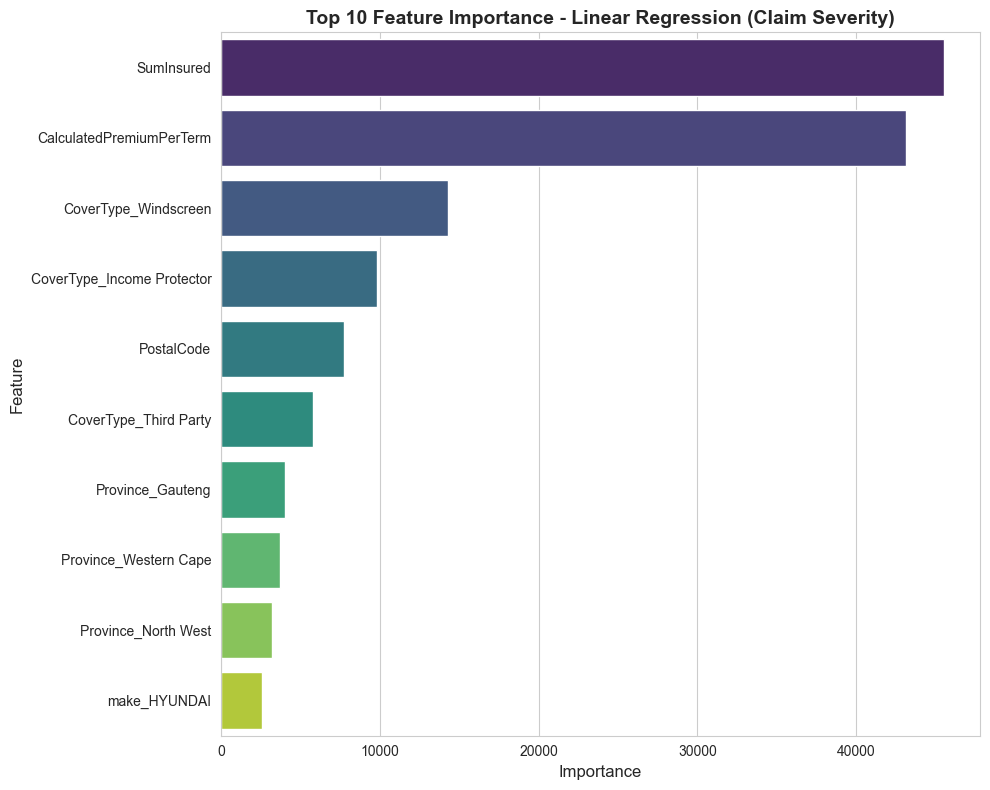

In [9]:
# Get feature importance for best claim severity model
best_sev_model_name = best_model_sev
best_sev_model = models_sev[best_sev_model_name][0]

importance_sev = get_feature_importance(best_sev_model, feature_names_sev)
print(f"\nTop 10 Features for {best_sev_model_name} (Claim Severity):")
print("="*80)
print(importance_sev.head(10).to_string(index=False))

# Plot feature importance
plot_feature_importance(
    importance_sev,
    top_n=10,
    title=f"Top 10 Feature Importance - {best_sev_model_name} (Claim Severity)",
    save_path=FIGURES_DIR / '10_feature_importance_claim_severity.png'
)



Top 10 Features for Random Forest (Premium Prediction):
                 feature  importance
CalculatedPremiumPerTerm    0.734069
              SumInsured    0.242533
              PostalCode    0.009902
           cubiccapacity    0.002740
        RegistrationYear    0.002107
               kilowatts    0.001344
             Gender_Male    0.001328
    Gender_Not specified    0.001112
  Province_KwaZulu-Natal    0.001024
        Province_Gauteng    0.000613


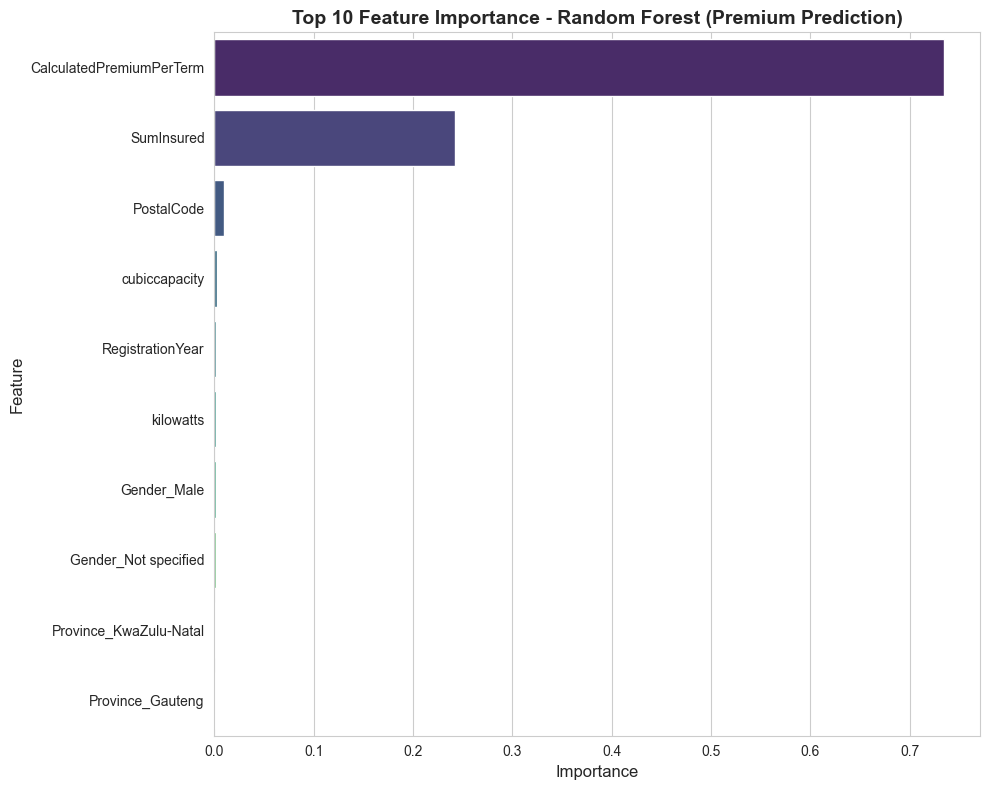

In [10]:
# Get feature importance for best premium prediction model
best_prem_model_name = best_model_prem
best_prem_model = models_prem[best_prem_model_name][0]

importance_prem = get_feature_importance(best_prem_model, feature_names_prem)
print(f"\nTop 10 Features for {best_prem_model_name} (Premium Prediction):")
print("="*80)
print(importance_prem.head(10).to_string(index=False))

# Plot feature importance
plot_feature_importance(
    importance_prem,
    top_n=10,
    title=f"Top 10 Feature Importance - {best_prem_model_name} (Premium Prediction)",
    save_path=FIGURES_DIR / '11_feature_importance_premium.png'
)


## SHAP Analysis (for Best Model)

Use SHAP to understand how individual features influence predictions.


Generating SHAP explanations for Linear Regression (Claim Severity)...


  0%|          | 0/100 [00:00<?, ?it/s]

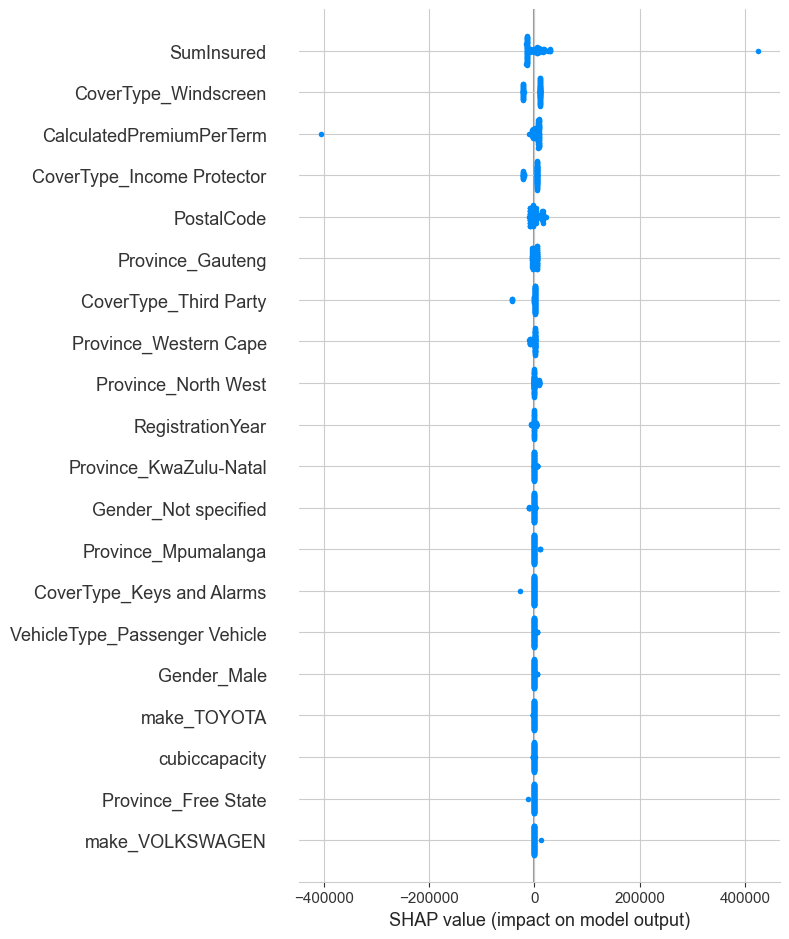


SHAP analysis completed!


In [11]:
# SHAP analysis for best claim severity model
print(f"Generating SHAP explanations for {best_sev_model_name} (Claim Severity)...")
shap_result_sev = explain_with_shap(
    best_sev_model,
    X_test_sev[:100],  # Use sample for faster computation
    feature_names_sev,
    max_evals=100
)

if shap_result_sev:
    plot_shap_summary(
        shap_result_sev,
        save_path=FIGURES_DIR / '12_shap_summary_claim_severity.png'
    )
    print("\nSHAP analysis completed!")
else:
    print("SHAP analysis not available. Install SHAP: pip install shap")


## Summary and Business Recommendations

Based on model performance and feature importance analysis.


In [12]:
print("\n" + "="*80)
print("MODELING SUMMARY")
print("="*80)

print("\n1. CLAIM SEVERITY PREDICTION:")
print(f"   Best Model: {best_sev_model_name}")
print(f"   Test R²: {comparison_sev.loc[comparison_sev['Model'] == best_sev_model_name, 'Test_R2'].values[0]:.4f}")
print(f"   Test RMSE: {comparison_sev.loc[comparison_sev['Model'] == best_sev_model_name, 'Test_RMSE'].values[0]:.2f} ZAR")
print(f"\n   Top 5 Features:")
for idx, row in importance_sev.head(5).iterrows():
    print(f"     - {row['feature']}: {row['importance']:.4f}")

print("\n2. PREMIUM PREDICTION:")
print(f"   Best Model: {best_prem_model_name}")
print(f"   Test R²: {comparison_prem.loc[comparison_prem['Model'] == best_prem_model_name, 'Test_R2'].values[0]:.4f}")
print(f"   Test RMSE: {comparison_prem.loc[comparison_prem['Model'] == best_prem_model_name, 'Test_RMSE'].values[0]:.2f} ZAR")
print(f"\n   Top 5 Features:")
for idx, row in importance_prem.head(5).iterrows():
    print(f"     - {row['feature']}: {row['importance']:.4f}")

print("\n" + "="*80)
print("Business Recommendations will be documented in the final report.")
print("="*80)



MODELING SUMMARY

1. CLAIM SEVERITY PREDICTION:
   Best Model: Linear Regression
   Test R²: 0.2749
   Test RMSE: 34148.28 ZAR

   Top 5 Features:
     - SumInsured: 45526.4720
     - CalculatedPremiumPerTerm: 43110.4049
     - CoverType_Windscreen: 14284.0912
     - CoverType_Income Protector: 9844.7516
     - PostalCode: 7719.3885

2. PREMIUM PREDICTION:
   Best Model: Random Forest
   Test R²: 0.6252
   Test RMSE: 107.59 ZAR

   Top 5 Features:
     - CalculatedPremiumPerTerm: 0.7341
     - SumInsured: 0.2425
     - PostalCode: 0.0099
     - cubiccapacity: 0.0027
     - RegistrationYear: 0.0021

Business Recommendations will be documented in the final report.
